# 2016-11-25: Support Vector Machines
In this lab, we will apply support vector classification methods to the Endometrium vs. Uterus cancer data. For documentation see: http://scikit-learn.org/0.17/modules/svm.html#svm

Let us start, as usual, by setting up our environment, loading the data, and setting up our cross-validation.

In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the data
X = np.loadtxt('data/small_Endometrium_Uterus.csv',  delimiter=',', skiprows=1, usecols=range(1, 3001))

# Python 3
y = np.loadtxt('data/small_Endometrium_Uterus.csv', delimiter=',', 
               skiprows=1, usecols=[3001], dtype='bytes').astype('str')
#Convert 'Endometrium' to 0 and 'Uterus' to 1
y = np.where(y=='Endometrium', 0, 1)

In [3]:
# Set up a stratified 10-fold cross-validation
from sklearn import cross_validation
folds = cross_validation.StratifiedKFold(y, 10, shuffle=True)

/Users/adrien/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Linear SVM

In [4]:
from sklearn import svm

### SVM decision function

SVMs do not naturally compute probabilities. It is possible to convert the output of the decision function into a probability, but that is a computationally intensive procedure, called Platt's scaling. You can read about it in the corresponding paper: https://www.microsoft.com/en-us/research/publication/probabilities-for-sv-machines/ 

The natural ways for SVMs to return scores (and not predicted classes) is to use the output of their decision function directly.

**Question:** Modify the `cross_validate` function to return as predictions the values of the decision function.

In [5]:
from sklearn import preprocessing

In [6]:
def cross_validate(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns, for each data point x, 
    the value of the decision function f computed when x was part of the test set. 
   
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - decision_function(X) to apply the trained classifier to the data X 
        and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape) # Hold all predictions, in correct order.
    i = 0
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]
        
        # Fit classifier
        classifier.fit(Xtr, ytr)

        # Compute decision function on test data
        output_decision_function = classifier.decision_function(Xte) 
        
        # Update pred 
        pred[te] = output_decision_function
        
    return pred

### Linear SVM with default C value

Let us cross-validate an SVM with linear kernel (linear soft-margin SVM) with default C parameter.

In [7]:
clf = svm.SVC(kernel='linear') 
ypred_linear = cross_validate(X, y, clf, folds)

**Question:** Plot the corresponding ROC curve.

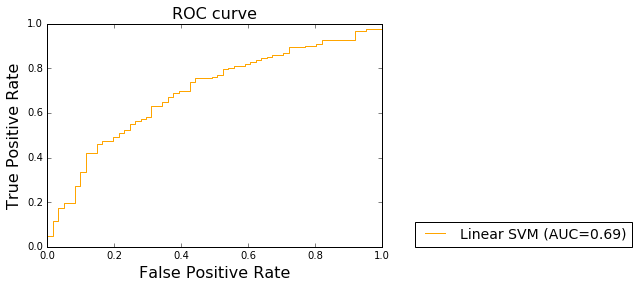

In [8]:
from sklearn import metrics
#No need to convert ypred_linear to binary values
#According to the documentation : ypred_linear could be either be probability 
#estimates of the positive class, confidence values, or non-thresholded measure of decisions
fpr_linear, tpr_linear, thresholds = metrics.roc_curve(y, ypred_linear, pos_label=1)
auc_linear = metrics.auc(fpr_linear, tpr_linear)

plt.plot(fpr_linear,tpr_linear, color='orange',
         label='Linear SVM (AUC=%.2f)' % auc_linear)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc=(1.1, 0), fontsize=14)

### Number of support vectors

The `n_support_` argument of an svm classifier gives us the number of support vectors for each class.

**Question:** How many support vectors does our classifier have? How many is this compared to the number of training samples?

In [33]:
print("Our classifier has {} support vectors for the 0 class and {} for the 1 class".format(clf.n_support_[0],clf.n_support_[1]))
print("This is then {:.1f} % of the total number of training samples".format((np.sum(clf.n_support_)/len(y))*100))

Our classifier has 55 support vectors for the 0 class and 55 for the 1 class
This is then 60.1 % of the total number of training samples


**Answer** Here, our classifier has 55 support vectors for the negative class and 55 for the positive class.

### Kernel matrix

The kernel matrix is the matrix of size $n \times n$ that has for entry $K_{ij}$ the value $k(x^i, x^j)$, where $k$ is the kernel function used.

In the case of the linear kernel, the kernel function is the dot product.

**Question** Plot the matrix K for the linear kernel.

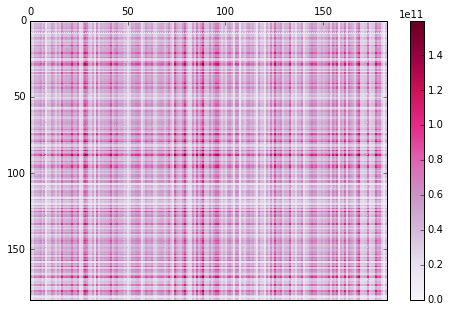

In [35]:
n_1,n_2 = np.shape(X)
kmatrix = np.zeros(np.shape(X)) 
for i in range(n_1):
    for j in range(n_1):
        kmatrix[i,j] = np.dot(X[i,:],X[j,:])
#Plot
fig = plt.figure(figsize=(8, 5))
# heatmap + color map
plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

# plot colorbar to the right
plt.colorbar()

# set axes boundaries
plt.xlim([0, X.shape[0]])
plt.ylim([0, X.shape[0]])

# flip the y-axis
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

**Question:** What do you observe about the values taken by the kernel? What happens if you scale the data before computing the kernel? 

**Answer** The kernel matrix sumarizes the similarities between data points. The matrix represented here contains values going from 0 to $10^{11}$. Indeed, the goal a kernel matrix is to have a big variance so that the data could be separated more easily. After scaling the data, the values are in the interval $[-3000,10500]$ and the matrix is more homogeneous.

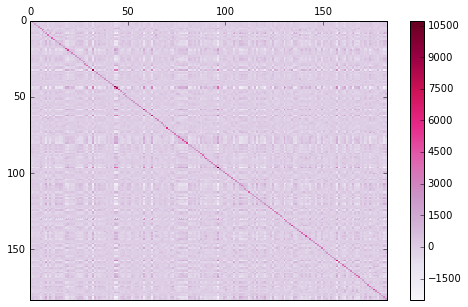

In [36]:
scaler = preprocessing.StandardScaler() # create scaler
X_scaled = scaler.fit_transform(X) # fit the scaler to the training data and transform training data
n_1,n_2 = np.shape(X)
kmatrix = np.zeros(np.shape(X)) 
for i in range(n_1):
    for j in range(n_1):
        kmatrix[i,j] = np.dot(X_scaled[i,:],X_scaled[j,:])
    
#Plot
fig = plt.figure(figsize=(8, 5))
# heatmap + color map
plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

# plot colorbar to the right
plt.colorbar()

# set axes boundaries
plt.xlim([0, X.shape[0]])
plt.ylim([0, X.shape[0]])

# flip the y-axis
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

**Question:** How does scaling affect the performance of the linear SVM?

**Answer** The performances increase significatively. Indeed, SVM is trying to minimize the distance between the separating plane and the support vectors. If one feature has very large values, it will dominate the other features when calculating the distance. If the features are scaled, they all have the same influence on the distance metric.

In [37]:
def cross_validate_with_scaling(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns, for each data point x, 
    the value of the decision function f computed when x was part of the test set. 
    
    Scale the training data, and apply same scaling to the test data.
   
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - decision_function(X) to apply the trained classifier to the data X 
        and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]
        
        scaler = preprocessing.StandardScaler() # create scaler
        Xtr = scaler.fit_transform(Xtr) # fit the scaler to the training data and transform training data
        Xte = scaler.transform(Xte) # transform test data
        
        # Fit classifier
        classifier.fit(Xtr, ytr)

        # Compute decision function on test data
        output_decision_function = classifier.decision_function(Xte)
        
        # Update pred
        pred[te] = output_decision_function
        
    return pred

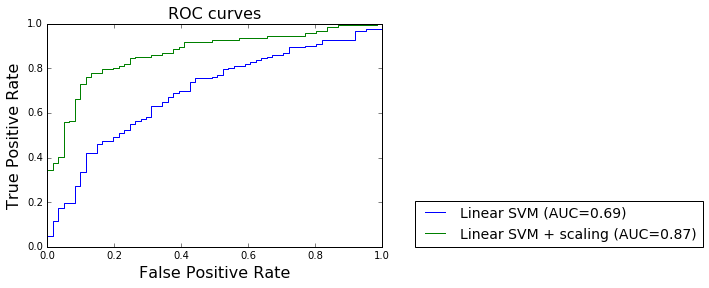

In [38]:
clf = svm.SVC(kernel='linear') 
ypred_linear_scaled = cross_validate_with_scaling(X, y, clf, folds)

fpr_linear_scaled, tpr_linear_scaled, thresholds = metrics.roc_curve(y, ypred_linear_scaled, pos_label=1)
auc_linear_scaled = metrics.auc(fpr_linear_scaled, tpr_linear_scaled)

plt.plot(fpr_linear,tpr_linear,
            label='Linear SVM (AUC=%.2f)' % auc_linear)
plt.plot(fpr_linear_scaled, tpr_linear_scaled,
            label='Linear SVM + scaling (AUC=%.2f)' % auc_linear_scaled)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc=(1.1, 0), fontsize=14)

**Question:** Now optimize for the C-parameter within each loop of the cross-validation. Plot the new ROC curve.

In [39]:
from sklearn import grid_search
parameters_dict = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
clf = grid_search.GridSearchCV(svm.SVC(kernel='linear') , parameters_dict, 
                               scoring='roc_auc')
ypred_linear_opt = cross_validate_with_scaling(X, y, clf, folds)

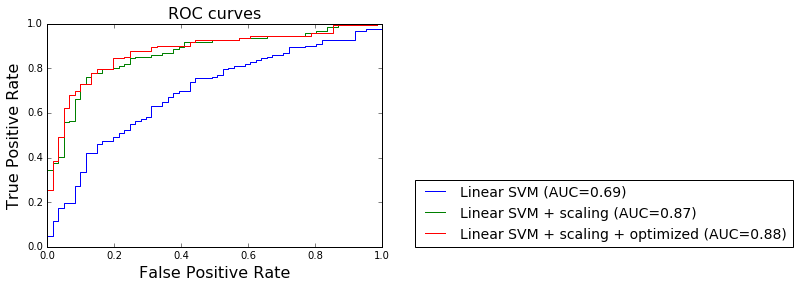

In [40]:
fpr_linear_opt, tpr_linear_opt, thresholds = metrics.roc_curve(y, ypred_linear_opt, pos_label=1)
auc_linear_opt = metrics.auc(fpr_linear_opt, tpr_linear_opt)

plt.plot(fpr_linear,tpr_linear,
            label='Linear SVM (AUC=%.2f)' % auc_linear)
plt.plot(fpr_linear_scaled, tpr_linear_scaled,
            label='Linear SVM + scaling (AUC=%.2f)' % auc_linear_scaled)
plt.plot(fpr_linear_opt, tpr_linear_opt,
            label='Linear SVM + scaling + optimized (AUC=%.2f)' % auc_linear_opt)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc=(1.1, 0), fontsize=14)

## Polynomial kernels

We will use SVMs with kernels of the form $k(x, x') = (\langle x, x' \rangle + r)^d$.

**Question** Plot kernel matrices for $r=0, d=2$.

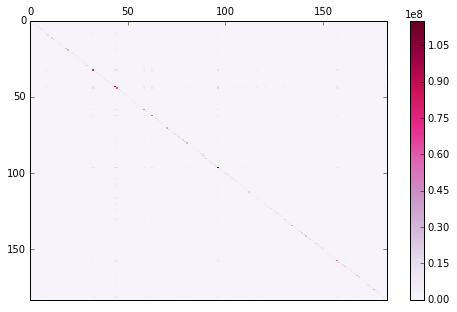

In [41]:
for i in range(n_1):
    for j in range(n_1):
        kmatrix[i,j] = (np.dot(X_scaled[i,:],X_scaled[j,:]))**2
#Plot
fig = plt.figure(figsize=(8,5))
# heatmap + color map
plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

# plot colorbar to the right
plt.colorbar()

# set axes boundaries
plt.xlim([0, X.shape[0]])
plt.ylim([0, X.shape[0]])

# flip the y-axis
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

**Question:** What do you observe? What is going to happen if you increase $d$? How do you think this will affect the SVM? Cross-validate the SVM and plot the ROC curve.

**Answer** Only a few points are colored on the plot. The matrix looks like the identity matrix. This will decrease the performance of the SVM classifier as points are only similars to each others. Indeed, similiraties between points are weakers when using this polynomial kernel. 

In [17]:
clf = svm.SVC(kernel='poly',degree = 2,coef0 = 0)
ypred_quadratic = cross_validate_with_scaling(X, y, clf, folds)

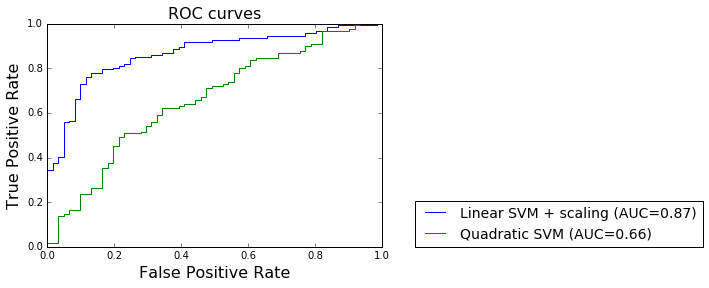

In [18]:
fpr_quadratic, tpr_quadratic, thresholds = metrics.roc_curve(y, ypred_quadratic, pos_label=1)
auc_quadratic = metrics.auc(fpr_quadratic, tpr_quadratic)

plt.plot(fpr_linear_scaled, tpr_linear_scaled,
            label='Linear SVM + scaling (AUC=%.2f)' % auc_linear_scaled)
plt.plot(fpr_quadratic, tpr_quadratic,
            label='Quadratic SVM (AUC=%.2f)' % auc_quadratic)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc=(1.1, 0), fontsize=14)

**Question** What value for $r$ can change this behavior? Plot the corresponding kernel matrix.

**Answer** When $r$ gets quite big, the matrix looks inhomogeneous again.

In [ ]:
for i in range(n_1):
    for j in range(n_1):
        kmatrix[i,j] = (np.dot(X_scaled[i,:],X_scaled[j,:])+10**4)**2
#Plot
fig = plt.figure(figsize=(8,5))
# heatmap + color map
plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

# plot colorbar to the right
plt.colorbar()

# set axes boundaries
plt.xlim([0, X.shape[0]])
plt.ylim([0, X.shape[0]])

# flip the y-axis
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

**Question** Now evaluate an SVM with polynomial kernel of degree d=2 and value for r as above.

In [ ]:
clf = svm.SVC(kernel='poly',degree = 2,coef0 = 10**4)
ypred_quadratic_2 = cross_validate_with_scaling(X, y, clf, folds)

In [ ]:
fpr_quadratic_2, tpr_quadratic_2, thresholds = metrics.roc_curve(y, ypred_quadratic_2, pos_label=1)
auc_quadratic_2 = metrics.auc(fpr_quadratic_2, tpr_quadratic_2)

# Plot
plt.plot(fpr_linear_scaled, tpr_linear_scaled,
            label='Linear SVM + scaling (AUC=%.2f)' % auc_linear_scaled)
plt.plot(fpr_quadratic_2, tpr_quadratic_2,
            label='Quadratic SVM (AUC=%.2f)' % auc_quadratic_2)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc=(1.1, 0), fontsize=14)

## Gaussian RBF kernels

We will use SVMs with kernels of the form $k(x, x') = \exp \left(-\gamma ||x - x'||^2 \right)$.

The following code efficiently computes the pairwise squared distances between all items in X, that is to say the matrix $P$ such that $P_{ij} = ||x^i - x^j||^2$.

In [ ]:
from scipy.spatial.distance import pdist, squareform
pairwise_sq_dists = squareform(pdist(X, 'sqeuclidean'))

**Question** Plot kernel matrices for varying values of $\gamma$. What do you observe? What is going to be the impact on the SVM? What happens with very very small values of $\gamma$? Check your intuitions by cross-validating SVMs with these various kernels.

In [ ]:
def f(gamma):
    return np.exp(-gamma*pairwise_sq_dists)

#Plot
fig = plt.figure(figsize=(18, 7))

fig.add_subplot(121) # 2 x 2 grid
# heatmap + color map
plt.title("Kernel matrix with $\gamma = 10^{-6}$", y = 1.08)
plt.pcolor(f(10**(-6)), cmap=matplotlib.cm.PuRd) 

# plot colorbar to the right
plt.colorbar()

# set axes boundaries
plt.xlim([0, X.shape[0]])
plt.ylim([0, X.shape[0]])

# flip the y-axis
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

fig.add_subplot(122) # 2 x 2 grid
# heatmap + color map
plt.title("Kernel matrix with $\gamma = 10^{-11}$", y = 1.08)
plt.pcolor(f(10**(-11)), cmap=matplotlib.cm.PuRd) 

# plot colorbar to the right
plt.colorbar()

# set axes boundaries
plt.xlim([0, X.shape[0]])
plt.ylim([0, X.shape[0]])

# flip the y-axis
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()


In [24]:
clf = svm.SVC(kernel='rbf',gamma = 10**(-6))
ypred_rbf = cross_validate_with_scaling(X, y, clf, folds)
fpr_rbf, tpr_rbf, thresholds = metrics.roc_curve(y, ypred_rbf, pos_label=1)
auc_rbf = metrics.auc(fpr_rbf, tpr_rbf)

clf = svm.SVC(kernel='rbf',gamma = 10**(-11))
ypred_rbf_2 = cross_validate_with_scaling(X, y, clf, folds)
fpr_rbf_2, tpr_rbf_2, thresholds = metrics.roc_curve(y, ypred_rbf_2, pos_label=1)
auc_rbf_2 = metrics.auc(fpr_rbf_2, tpr_rbf_2)

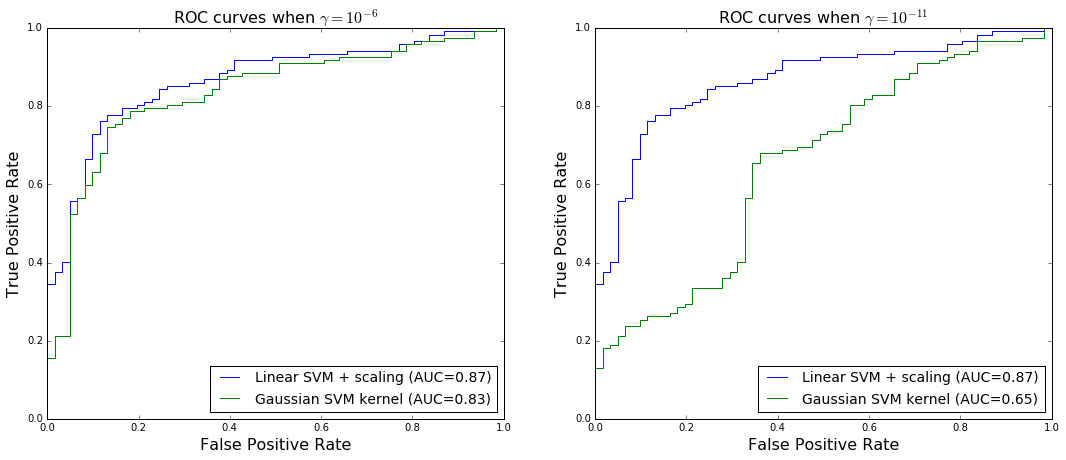

In [25]:
#2 subplots
fig = plt.figure(figsize=(18, 7))

# Plot 1
fig.add_subplot(121) # 2 x 2 grid

plt.plot(fpr_linear_scaled, tpr_linear_scaled,
            label='Linear SVM + scaling (AUC=%.2f)' % auc_linear_scaled)
plt.plot(fpr_rbf, tpr_rbf,
            label='Gaussian SVM kernel (AUC=%.2f)' % auc_rbf)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves when $\gamma = 10^{-6}$', fontsize=16)
plt.legend(loc = 4, fontsize=14)

# Plot 2
fig.add_subplot(122) # 2 x 2 grid

plt.plot(fpr_linear_scaled, tpr_linear_scaled,
            label='Linear SVM + scaling (AUC=%.2f)' % auc_linear_scaled)
plt.plot(fpr_rbf_2, tpr_rbf_2,
            label='Gaussian SVM kernel (AUC=%.2f)' % auc_rbf_2)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves when $\gamma = 10^{-11}$', fontsize=16)
plt.legend(loc = 4, fontsize=14)

**Answer** When using $\gamma = 10^{-6}$, the matrix looks quite like the identity matrix. Yet, this value of $\gamma$ gives the best AUC score. In fact, when $\gamma \not \in [10^{-3},10^{-7}]$, the SVM classifier gives very poor results.

## (Bonus) Scaling the kernel matrix.

What we have observed here is a phenomenon of diagonal dominance in the kernel matrix. 

One way to address this is to re-scale the kernel matrix in the following way:
$\hat K_{ij} = \frac{K_{ij}}{\sqrt{K_{ii} K_{jj}}}$.

To implement this you can pass your own kernel function or matrix to the `kernel` parameter of the SVM.

**Question:** Write a function `scaled_quadratic_kernel` that computes the scaled quadratic kernel matrix between two data arrays.

In [26]:
print(exp(-gamma*np.linalg.norm(Z)))
def k(x,y):
    Z = x - y
    return exp(-gamma*np.linalg.norm(Z))

def scaled_quadratic_kernel(X1,X2):
    
    """ Custom scaled RBF kernel.
    
    The RBF kernel between X1 and X2 is scaled to avoid diagonal dominance,
    by applying k(X1i, X2j) <-- k(X1i, X2j) / sqrt(k(X1i, X1i) k(X2j, X2j))   
   
    Parameters:
    -----------
    X1: (n_samples1, n_features) np.array
        First data matrix.
    X2: (n_samples2, n_features) np.array
        Second data matrix.
        
    Return:
    -------
    K: (n_samples1, n_samples2) np.array
        Kernel matrix between samples from X1 and samples from X2.
    """
    n_1, p = np.shape(X1)
    n_2, p = np.shape(X2)
    
    for i in range(n_1):
        for j in range(n_2):
            K[i,j] = k(X1[i,:],X2[j,:])/np.sqrt(k(X1[i,:],X1[i,:])*k(X2[j,:],X2[j,:]))
    return K

TypeError: bad operand type for unary -: 'builtin_function_or_method'

**Question:** Plot the corresponding kernel matrix. Does it match your expectations?

In [ ]:
kmatrix_scaled = scaled_quadratic_kernel(X,X,gamma)
kmatrix = f(10**(-6))

np.savetxt("kmatrix",kmatrix,delimiter=",")
np.savetxt("kmatrix_scaled",kmatrix_scaled,delimiter=",")
#Plot
fig = plt.figure(figsize=(9, 7))
# heatmap + color map
plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

# plot colorbar to the right
plt.colorbar()

# set axes boundaries
plt.xlim([0, X.shape[0]])
plt.ylim([0, X.shape[0]])

# flip the y-axis
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

**Question:** In the 0.17 version of scikit-learn, it isn't possible to use a custom kernel function within GridSearchCV. Set the C parameter to 1 and compare your custom kernel with the quadratic kernel (d=2) on the gene expression data.

In [ ]:
clf = svm.SVC(kernel='rbf',gamma = 10**(-6))
ypred_rbf = cross_validate_with_scaling(X, y, clf, folds)
fpr_rbf, tpr_rbf, thresholds = metrics.roc_curve(y, ypred_rbf, pos_label=1)
auc_rbf = metrics.auc(fpr_rbf, tpr_rbf)

clf = svm.SVC(kernel=scaled_quadratic_kernel, gamma = 10**(-6))
ypred_rbf_2 = cross_validate_with_scaling(X, y, clf, folds)
fpr_rbf_2, tpr_rbf_2, thresholds = metrics.roc_curve(y, ypred_rbf_2, pos_label=1)
auc_rbf_2 = metrics.auc(fpr_rbf_2, tpr_rbf_2)

In [ ]:
#2 subplots
fig = plt.figure(figsize=(18, 7))

# Plot 1
fig.add_subplot(121) # 2 x 2 grid

#plt.plot(fpr_linear_scaled, tpr_linear_scaled,
#            label='Linear SVM + scaling (AUC=%.2f)' % auc_linear_scaled)
plt.plot(fpr_rbf, tpr_rbf,
            label='Gaussian SVM kernel (AUC=%.2f)' % auc_rbf)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves when $\gamma = 10^{-6}$', fontsize=16)
plt.legend(loc = 4, fontsize=14)

# Plot 2
fig.add_subplot(122) # 2 x 2 grid

#plt.plot(fpr_linear_scaled, tpr_linear_scaled,
#            label='Linear SVM + scaling (AUC=%.2f)' % auc_linear_scaled)
plt.plot(fpr_rbf_2, tpr_rbf_2,
            label='Gaussian SVM kernel (AUC=%.2f)' % auc_rbf_2)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves when $\gamma = 10^{-11}$', fontsize=16)
plt.legend(loc = 4, fontsize=14)